In [4]:
import nexfile as nex
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from tkinter import filedialog
from tkinter import *
%writefile build_unit.py
%matplotlib inline

class Marker:
    def __init__(self,record,door,protocol):
        self.record=record
        self.door=door
        self.protocol=protocol
        
class Waveform:
    def __init__(self,timestamps,values,sr):
        self.timestamps=timestamps
        self.values=values
        self.sr=sr
        self.peak_trough_dur=FindPTdur(self.values,self.sr)
    def Plotwf(self):
        avgwf=np.mean(self.values,axis=0)
        sdwf=np.std(self.values,axis=0)
        x=np.linspace(1,len(avgwf),len(avgwf))  #*(1/self.sr)*1000
        plt.plot(x,avgwf)
        plt.fill_between(x,avgwf+sdwf,avgwf-sdwf,alpha=0.3)
        plt.show()
        print('Peak-Trough duration is %.3f ms' %self.peak_trough_dur)

#Calculate the peak trough duration 
def FindPTdur(wfvalue,samplingrate):
    avgwf=np.mean(wfvalue,axis=0)
    avgquad=avgwf.reshape(4,-1)
    return (avgquad.min(axis=0).argmax()-avgquad.min(axis=0).argmin())*(1/samplingrate)*1000 #in ms
    
class Unit:
    def __init__(self,spktrain,marker,waveform): #marker and waveform are class as well 
        self.spktrain=spktrain
        self.marker=marker
        self.waveform=waveform 
        self.ctx=self.split_context()
        self.cdi=[calc_cdi(self.ctx),calc_cdi(self.ctx,method=1)]
        
    def split_context(self,plot_ctx=False,plot_buffer=False):
        context=[{} for x in range(len(np.unique(self.marker.protocol))+1)]

        #construct the explored context 
        for c,ctx in enumerate(np.unique(self.marker.protocol)):
            context[c]['name']=ctx
            context[c]['index']=np.where(np.asarray(self.marker.protocol)==ctx)[0] #find the indices of specific contexts 
            context[c]['spkt']=[]
            context[c]['spkc']=[]
            context[c]['dur']=[]
            context[c]['fr']=[]
            for n,t in enumerate(context[c]['index']):
                context[c]['spkt'].append(self.spktrain[(self.spktrain>=self.marker.door[0][t]) \
                                                        &(self.spktrain<=self.marker.record[1][t])]-self.marker.door[0][t])
                context[c]['spkc'].append(context[c]['spkt'][n].size)
                context[c]['dur'].append(self.marker.record[1][t]-self.marker.door[0][t])
                context[c]['fr'].append(context[c]['spkt'][n].size/context[c]['dur'][n])
                #we define here from door open to record end 

        #construct the buffer context 
        context[-1]['name']='buffer'
        context[-1]['index']=np.asarray([int(i) for i in range(len(self.marker.protocol))])
        context[-1]['spkt']=[]
        context[-1]['spkc']=[]
        context[-1]['dur']=[]
        context[-1]['fr']=[]
        for n,t in enumerate(context[-1]['index']):
            context[-1]['spkt'].append(self.spktrain[(self.spktrain>=self.marker.record[0][t]) \
                                                        &(self.spktrain<=self.marker.door[0][t])]-self.marker.record[0][t])
            context[-1]['spkc'].append(context[-1]['spkt'][n].size)
            context[-1]['dur'].append(self.marker.door[0][t]-self.marker.record[0][t])
            context[-1]['fr'].append(context[-1]['spkt'][n].size/context[-1]['dur'][n])
            #we define here from record start to door open 
        
        #Plot the spike histogram for context A and B
        if plot_ctx:
            print('CDI:' + str(self.cdi))
            i=0;
            top=[]
            ax=[]
            fig=plt.figure(figsize=(8,4))
            for c in range(2):    
                for t,spk in enumerate(context[c]['spkt']): 
                    ax.append(fig.add_subplot(2,4,4*c+t+1))
                    top.append(plot_spkhist(spk,ax[i]))
                    i+=1
            for j,axis in enumerate(ax): #set the ylim the same across trials
                axis.set_ylim([0,max(top)])
                if j!=0:
                    axis.set_ylabel('')
                    axis.get_yaxis().set_visible(False)
                    
        if plot_buffer:
            i=0;
            axbuffer=[]  
            top2=[]
            fig2=plt.figure(figsize=(8,2))
            for t,spk in enumerate(context[-1]['spkt']): 
                axbuffer.append(fig2.add_subplot(1,8,t+1))
                top2.append(plot_spkhist(spk,axbuffer[i],tlim=(0,60)))
                i+=1
            for j,axis in enumerate(axbuffer): #set the ylim the same across trials
                if max(top2)<max(top):
                    axis.set_ylim([0,max(top)])
                else:
                    axis.set_ylim([0,max(top2)])
                if j!=0:
                    axis.set_ylabel('')
                    axis.get_yaxis().set_visible(False)
        return context

    
    def split_trial(self): #split by trial, which contain both       
        trial=[{} for x in range(len(self.marker.record[0]))]
        for t,(tstart,tend) in enumerate(zip(self.marker.record[0], self.marker.record[1])):            
            trial[t]['spkt']=(self.spktrain[(self.spktrain>=tstart) & (self.spktrain<=tend)]-tstart)
            trial[t]['name']=self.marker.protocol[t]
        return trial

#The primary function for builidng a unit 
def buildneurons(pathname=os.path.join(os.getcwd(),'nexdata'),filename='03062019001-008'):
    #import nex file with a GUI window 
    try:
        filepath=os.path.join(pathname,filename)+'.nex'
        nexin=nex.Reader(useNumpy=True).ReadNexFile(filepath)
    except:
        root = Tk()
        filepath=filedialog.askopenfilename(initialdir=os.getcwd(),title='Select File')
        root.destroy()
        nexin=nex.Reader(useNumpy=True).ReadNexFile(filepath)
    neurons=[]
    waveforms=[]
    events=[]
    markers=[]

    for var in nexin['Variables']:
        if var['Header']['Type']==0:
            neurons.append(var)
            #print('neuron',len(neurons))
        if var['Header']['Type']==1:
            events.append(var)
            #print('events',len(events))
        if var['Header']['Type']==3:
            waveforms.append(var)
            #print('waveforms',len(waveforms))
        if var['Header']['Type'] == 6 and len(var['Timestamps']) != 0:
            markers.append(var)
            #print('markers',len(markers))    
    
    #ask for user input of context protocol
    input_protocol=[str(x) for x in input('Enter the order of context protocol: ').split() or 'A B A B A B B A'.split()] 
    print(input_protocol)
    
    record_marker=[events[0]['Timestamps'],events[1]['Timestamps']]
    door_marker=[]
    for mrker in markers:
        if mrker['Header']['Name']=='KBD1':
            door_marker.insert(0,mrker['Timestamps'])
        elif mrker['Header']['Name']=='KBD3':
            door_marker.insert(1,mrker['Timestamps'])
    door_marker=door_marker[0:2]
    allmarker=Marker(record_marker,door_marker,input_protocol)
    ensemble=[]
    for i in range(1,len(neurons)):
        ensemble.append(Unit(neurons[i]['Timestamps'],allmarker,Waveform(waveforms[i]['Timestamps'],waveforms[i]['WaveformValues'],waveforms[i]['Header']['SamplingRate'])))
    return ensemble

### Some general plot functions are defined here ###

#1. raster
def plot_raster(neuralData,linecolor=[0,0,0],linesize=0.5,x='trial#',title_name='Spike raster plot'):
    plt.eventplot(neuralData,color=linecolor,linelengths=linesize)
    plt.title(title_name)
    plt.ylabel(x)

#2. spike histogram
def plot_spkhist(neuralData,ax,dt=5,tlim=(0,300)):
    spkc_hist=np.histogram(neuralData,bins=tlim[1]//dt,range=tlim)
    fr_hist=spkc_hist[0]/dt
    plt.bar(spkc_hist[1][:-1],fr_hist,width=dt)
    plt.xlabel('Time (s)')
    plt.ylabel('Firing rate (Hz)')
    ylimit=ax.get_ylim()
    return ylimit[1]


### Numeric computation functions are defined here ###
def calc_cdi(context,method=0):
    if method==0:
        avg_fr=[]
        for i in range(2):
            avg_fr.append(sum(context[i]['spkc'])/sum(context[i]['dur']))
        cdi=(avg_fr[0]-avg_fr[1])/(avg_fr[0]+avg_fr[1])
    elif method==1:
        cdi_singletrial=[]
        for fr1,fr2 in zip(context[0]['fr'],context[1]['fr']):
            cdi_singletrial.append((fr1-fr2)/(fr1+fr2))
        cdi=np.mean(np.asarray(cdi_singletrial))
        
    return cdi

UsageError: Line magic function `%writefile` not found (But cell magic `%%writefile` exists, did you mean that instead?).


In [276]:
def bootstrap_context(Unit,eval_method='cdi',shuffle_num=10000):
    init_t=0
    spkt_ob=[]
    tstart=[]
    tend=[]
    dur=[]
    ttemp=0
    #create a long spiketrain containing only spikes from context 
    for i,record_end in enumerate(Unit.marker.record[1]):
        spkctx=Unit.spktrain[(Unit.spktrain>=Unit.marker.door[0][i])&(Unit.spktrain<=record_end)]-Unit.marker.door[0][i]
        spkt_ob.append(spkctx+init_t)
        dur.append((record_end-Unit.marker.door[0][i]))
        init_t+=dur[i]
        tstart.append(ttemp)
        tend.append(ttemp+dur[i])
        ttemp+=dur[i]        
    spkt_observed=np.concatenate(spkt_ob)
    #keep the ISI the same but shuffled 
    ISI=np.insert(np.diff(spkt_observed),0,Unit.spktrain[1])  
    #create pseudo spiketrains
    spk_shuffle=[]
    for i in range(shuffle_num):
        spk_new=[]
        currentspk=0
        new_ISI=np.random.permutation(ISI)
        for isi in new_ISI:
            spk_new.append(currentspk+isi)
            currentspk+=isi
        spk_shuffle.append(np.array(spk_new))
    cdi_observed=cal_ctx_cdi(spkt_observed,Unit,tstart,tend,dur)
    cdi_shuffle=[]
    for spk_s in spk_shuffle:
        cdi_shuffle.append(cal_ctx_cdi(spk_s,Unit,tstart,tend,dur))
               
    return cdi_observed,cdi_shuffle
    
def cal_ctx_cdi(spk,Unit,tstart,tend,dur):
    ctx_bs=[{} for x in range(len(np.unique(Unit.marker.protocol)))]       
    for c,ctx in enumerate(np.unique(Unit.marker.protocol)):
        ctx_bs[c]['name']=ctx
        ctx_bs[c]['index']=np.where(np.asarray(Unit.marker.protocol)==ctx)[0]
        ctx_bs[c]['spkt']=[]
        ctx_bs[c]['spkc']=[]
        ctx_bs[c]['dur']=[]
        ctx_bs[c]['fr']=[]
        for n,t in enumerate(ctx_bs[c]['index']):
            ctx_bs[c]['spkt'].append(spk[(spk>=tstart[t]) & (spk<=tend[t])])
            ctx_bs[c]['dur'].append(dur[t])
            ctx_bs[c]['spkc'].append(ctx_bs[c]['spkt'][n].size)
            ctx_bs[c]['fr'].append(ctx_bs[c]['spkc'][n]/dur[t])
    avg_fr=[]
    for i in range(2):
        avg_fr.append(sum(ctx_bs[i]['spkc'])/sum(ctx_bs[i]['dur']))
    cdi=(avg_fr[0]-avg_fr[1])/(avg_fr[0]+avg_fr[1])
    return cdi


In [111]:
ensemble=buildneurons()

Enter the order of context protocol:  


['A', 'B', 'A', 'B', 'A', 'B', 'B', 'A']


CDI:[-0.25028448480660825, -0.2488872421623617]


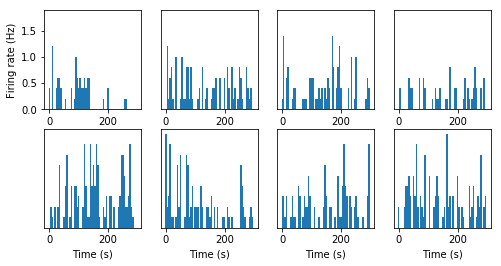

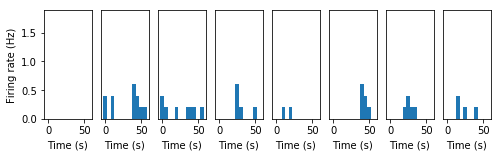

In [288]:
myUnit=ensemble[6]
ctx=myUnit.split_context(plot_ctx=True,plot_buffer=True)

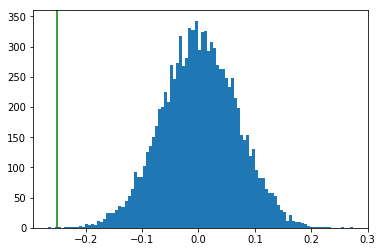

In [289]:
cdi1,cdi2=bootstrap_context(myUnit)
plt.hist(cdi2,bins=100)
plt.axvline(cdi1,color='g')
plt.show()